# ML Pipeline Using Data Subset Selection, PCA, ReliefF and LightGBM

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 


import arff
data_freq = arff.load('freMTPL2freq.arff') 
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
df_freq.head()
df_freq.info()
df_freq.describe()
   

data_sev = arff.load('freMTPL2sev.arff') 
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "PurePremium"])
df_sev.head()
df_sev.info()
df_sev.describe()

# Merge the dataframes on the common 'IDpol' values
combined_df = pd.merge(df_freq, df_sev, on='IDpol')

# Print the information about the combined dataframe
combined_df.head()
combined_df.info()
combined_df.describe()


# Create the new column "PurePremium" by dividing "PurePremium" by "Exposure"
combined_df['PurePremium'] = combined_df['PurePremium'] / combined_df['Exposure']

# Remove the columns 
combined_df.pop('IDpol')
combined_df.pop('Exposure')

combined_df.info()

y_premium_column = combined_df.pop('PurePremium')
combined_df['PurePremium'] = y_premium_column

print("Missing values:\n", combined_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   PurePremi

# Oberving PurePremium < 0.75 Quantile

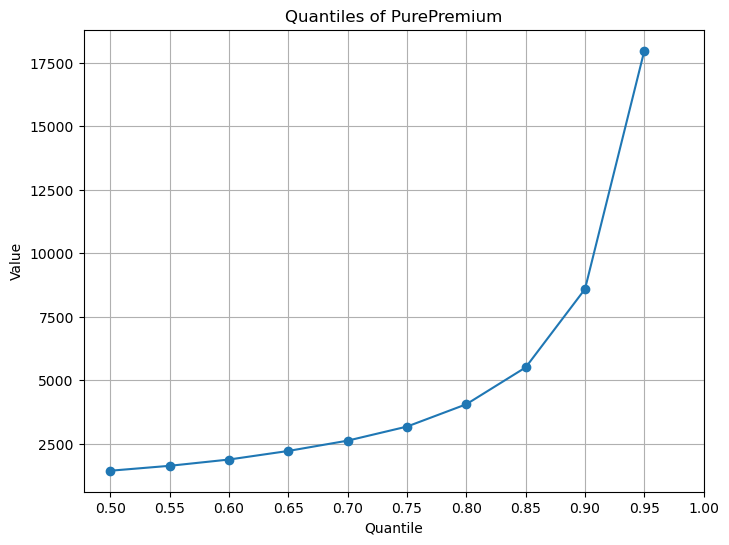

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Quantiles to compute
quantiles = np.arange(0.5, 1.0, 0.05)

# Compute quantiles
quantile_values = [combined_df['PurePremium'].quantile(q) for q in quantiles]

# Plot quantiles
plt.figure(figsize=(8, 6))
plt.plot(quantiles, quantile_values, marker='o', linestyle='-')
plt.title('Quantiles of PurePremium')
plt.xlabel('Quantile')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(np.arange(0.5, 1.05, 0.05))
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19833 entries, 0 to 26431
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ClaimNb      19833 non-null  float64
 1   Area         19833 non-null  object 
 2   VehPower     19833 non-null  float64
 3   VehAge       19833 non-null  float64
 4   DrivAge      19833 non-null  float64
 5   BonusMalus   19833 non-null  float64
 6   VehBrand     19833 non-null  object 
 7   VehGas       19833 non-null  object 
 8   Density      19833 non-null  float64
 9   Region       19833 non-null  object 
 10  PurePremium  19833 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.8+ MB
None
           ClaimNb      VehPower        VehAge       DrivAge    BonusMalus  \
count  19833.00000  19833.000000  19833.000000  19833.000000  19833.000000   
mean       1.12091      6.462512      7.407452     45.890536     64.458327   
std        0.43322      2.006901      5.146073     14.

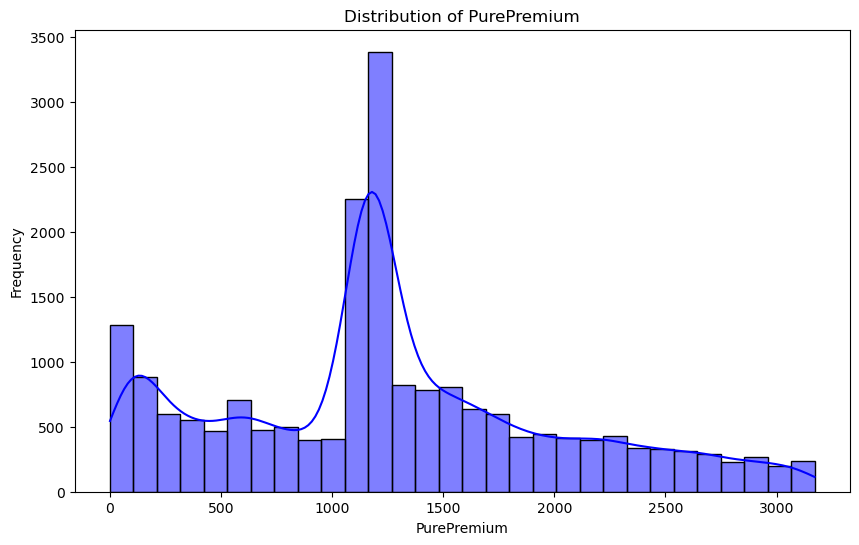

In [3]:
# Training untill 75th percentile as threshold

# Find the 75th percentile of PurePremium
quantile_75 = combined_df['PurePremium'].quantile(0.75)

# Find the 95th percentile of PurePremium
quantile_95 = combined_df['PurePremium'].quantile(0.95)

# Split the data into DF1 (above 75th percentile) and DF2 (below or equal to 75th percentile)
DF1 = combined_df[combined_df['PurePremium'] > quantile_75]
DF2 = combined_df[combined_df['PurePremium'] <= quantile_75]


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the DataFrame
print(DF2.info())

# Display summary statistics for numerical columns
print(DF2.describe())

# Check for missing values
print("Missing values:\n", DF2.isnull().sum())

# Visualize the distribution of the target variable 'PurePremium'
plt.figure(figsize=(10, 6))
sns.histplot(DF2['PurePremium'], bins=30, kde=True, color='blue')
plt.title('Distribution of PurePremium')
plt.xlabel('PurePremium')
plt.ylabel('Frequency')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18232\3576395462.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(DF2.corr(), annot=True, cmap='coolwarm', fmt=".2f")


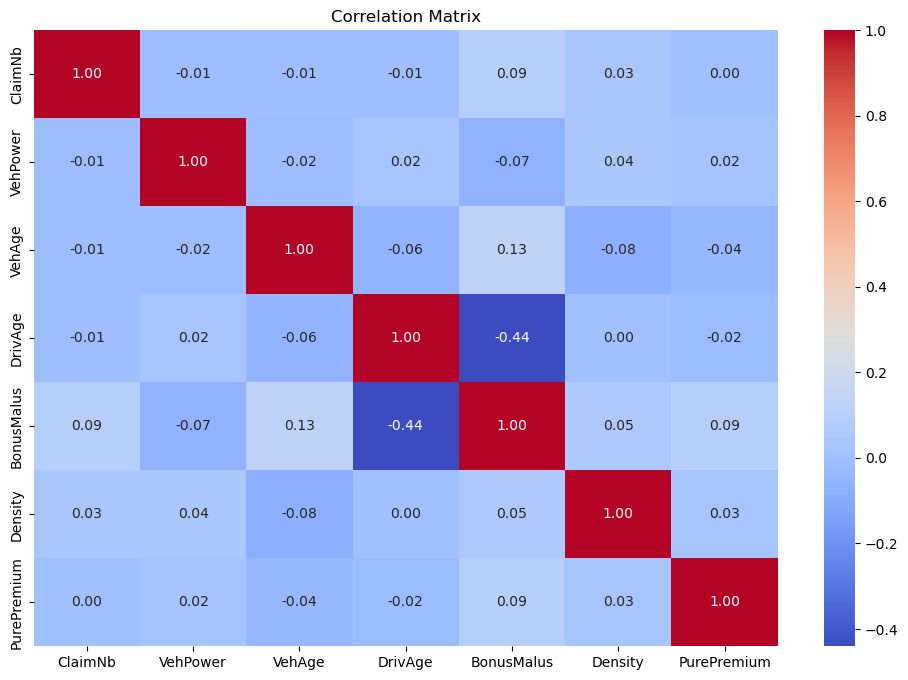

In [4]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(DF2.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Removing Outliers for Pure Premium

In [5]:
combined_df = DF2.copy()

combined_df.info()


import numpy as np

# Calculate the Z-score for 'PurePremium' column
z_scores = np.abs((combined_df['PurePremium'] - combined_df['PurePremium'].mean()) / combined_df['PurePremium'].std())

# Define the threshold for outliers (e.g., Z-score greater than 3)
threshold = 3

# Find the indices of outliers
outlier_indices = np.where(z_scores > threshold)[0]

# Create a DataFrame containing only the outliers
df_outliers = combined_df.iloc[outlier_indices]

# Print the shape of the outliers DataFrame
print("Shape of outliers DataFrame:", df_outliers.shape)

df_scaled_cleaned = combined_df.drop(outlier_indices)

combined_df = df_scaled_cleaned.copy()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19833 entries, 0 to 26431
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ClaimNb      19833 non-null  float64
 1   Area         19833 non-null  object 
 2   VehPower     19833 non-null  float64
 3   VehAge       19833 non-null  float64
 4   DrivAge      19833 non-null  float64
 5   BonusMalus   19833 non-null  float64
 6   VehBrand     19833 non-null  object 
 7   VehGas       19833 non-null  object 
 8   Density      19833 non-null  float64
 9   Region       19833 non-null  object 
 10  PurePremium  19833 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.8+ MB
Shape of outliers DataFrame: (0, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19833 entries, 0 to 26431
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ClaimNb      19833 non-null  float64
 1   Area         198

# Scaling and Encoding Input Features

In [6]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Features to be Normalised
numerical_features = ['ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Features to be encoded
columns_to_encode = ['Area', 'VehBrand', 'VehGas', 'Region']

# Copy the DataFrame to avoid modifying the original
data = combined_df.copy()

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())                     # Scale the features
])

# Apply the pipeline to numerical features
data[numerical_features] = pipeline.fit_transform(data[numerical_features])

# Apply one-hot encoding
data = pd.get_dummies(data, columns=columns_to_encode, drop_first=True)


y_premium_column = data.pop('PurePremium')
data['PurePremium'] = y_premium_column

df = data.copy()
df.info()
df.describe()
print("Missing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19833 entries, 0 to 26431
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClaimNb         19833 non-null  float64
 1   VehPower        19833 non-null  float64
 2   VehAge          19833 non-null  float64
 3   DrivAge         19833 non-null  float64
 4   BonusMalus      19833 non-null  float64
 5   Density         19833 non-null  float64
 6   Area_'B'        19833 non-null  uint8  
 7   Area_'C'        19833 non-null  uint8  
 8   Area_'D'        19833 non-null  uint8  
 9   Area_'E'        19833 non-null  uint8  
 10  Area_'F'        19833 non-null  uint8  
 11  VehBrand_'B10'  19833 non-null  uint8  
 12  VehBrand_'B11'  19833 non-null  uint8  
 13  VehBrand_'B12'  19833 non-null  uint8  
 14  VehBrand_'B13'  19833 non-null  uint8  
 15  VehBrand_'B14'  19833 non-null  uint8  
 16  VehBrand_'B2'   19833 non-null  uint8  
 17  VehBrand_'B3'   19833 non-null 

# Removing Outliers for Numerical Columns

ClaimNb             1.000025
VehPower            1.000025
VehAge              1.000025
DrivAge             1.000025
BonusMalus          1.000025
Density             1.000025
Area_'B'            0.301594
Area_'C'            0.444702
Area_'D'            0.426635
Area_'E'            0.418109
Area_'F'            0.168071
VehBrand_'B10'      0.168495
VehBrand_'B11'      0.153836
VehBrand_'B12'      0.354494
VehBrand_'B13'      0.142629
VehBrand_'B14'      0.070830
VehBrand_'B2'       0.438408
VehBrand_'B3'       0.286984
VehBrand_'B4'       0.200481
VehBrand_'B5'       0.247318
VehBrand_'B6'       0.212274
VehGas_Regular      0.499945
Region_'R21'        0.052589
Region_'R22'        0.110459
Region_'R23'        0.083127
Region_'R24'        0.436792
Region_'R25'        0.133321
Region_'R26'        0.109565
Region_'R31'        0.179234
Region_'R41'        0.133685
Region_'R42'        0.058882
Region_'R43'        0.030113
Region_'R52'        0.241469
Region_'R53'        0.264009
Region_'R54'  

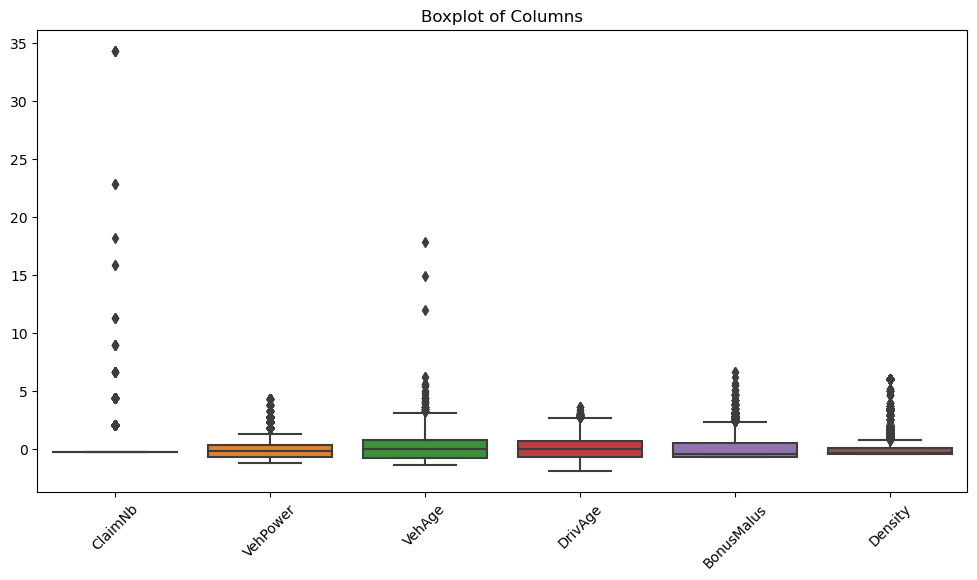

Indices of Outliers: {0, 1, 16384, 3, 16388, 16385, 6, 16387, 16393, 16394, 16396, 13, 16399, 16, 17, 16401, 20, 16406, 23, 25, 26, 29, 30, 31, 16413, 16415, 34, 35, 16416, 16420, 38, 16421, 16422, 16425, 16426, 43, 44, 16429, 16430, 47, 45, 16432, 16435, 52, 53, 54, 55, 16437, 16439, 16440, 16441, 60, 16443, 16444, 16445, 64, 65, 16446, 16447, 16448, 16452, 16454, 71, 16457, 76, 80, 81, 16470, 87, 16473, 16474, 91, 16476, 16477, 16479, 96, 16482, 16483, 16484, 16490, 109, 110, 16498, 16499, 16500, 16501, 16502, 16503, 16505, 16506, 16507, 16508, 16509, 16513, 16514, 139, 16527, 144, 145, 16528, 147, 148, 16531, 16534, 16533, 16535, 153, 16537, 16539, 16541, 158, 16542, 162, 16547, 16548, 16549, 168, 176, 178, 179, 16568, 189, 16573, 16576, 16577, 195, 16584, 16587, 16591, 209, 210, 16593, 213, 214, 16600, 16601, 220, 227, 16611, 16612, 16613, 16617, 16624, 16625, 16630, 16633, 16635, 16636, 254, 255, 256, 257, 16638, 262, 16646, 16648, 16649, 16651, 16653, 270, 282, 291, 16676, 16677,

In [7]:

## Understand std deviation of features
column_std = df.std()
print(column_std)


# Removing Outliers from numerical features
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the data
columns_of_interest = ['ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Step 1: Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[columns_of_interest])
plt.title('Boxplot of Columns')
plt.xticks(rotation=45)
plt.show()

# Step 2: Z-Score Method
from scipy import stats

z_scores = np.abs(stats.zscore(df[columns_of_interest]))
threshold = 3
outliers_z = np.where(z_scores > threshold)

# Step 3: IQR Method
Q1 = df[columns_of_interest].quantile(0.25)
Q3 = df[columns_of_interest].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = ((df[columns_of_interest] < lower_bound) | (df[columns_of_interest] > upper_bound)).any(axis=1)

# Combine results
outliers = set(outliers_z[0]) | set(outliers_iqr.index[outliers_iqr])

print("Indices of Outliers:", outliers)

# Remove outliers identified by IQR method
df_no_outliers_iqr = df[~outliers_iqr]
df = df_no_outliers_iqr.copy()

# Print the shape of the original and updated DataFrames to see the difference
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing outliers (IQR method):", df_no_outliers_iqr.shape)


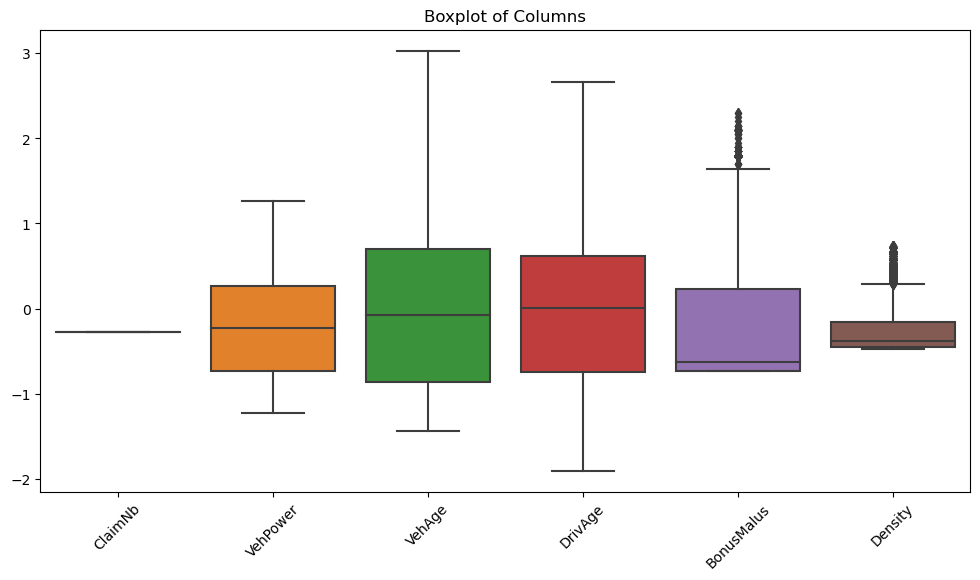

In [8]:
# After removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[columns_of_interest])
plt.title('Boxplot of Columns')
plt.xticks(rotation=45)
plt.show()

# Model Training, Validation and Testing with LightGBM

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score

# Create an empty list to store results
results_lightgbm_train = []
results_lightgbm_test = []

# Splitting the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0)

# Using numpy to create arrays of labels and features
y_train_PurePremium = np.array(train_df['PurePremium'])
y_val_PurePremium = np.array(val_df['PurePremium'])
y_test_PurePremium = np.array(test_df['PurePremium'])
train_features = np.array(train_df.iloc[:, 0:43])
val_features = np.array(val_df.iloc[:, 0:43])
test_features = np.array(test_df.iloc[:, 0:43])

# Hyperparameter tuning using validation set
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

dtrain = lgb.Dataset(train_features, label=y_train_PurePremium)
dval = lgb.Dataset(val_features, label=y_val_PurePremium)

# Training the LightGBM model
clf_lightgbm = lgb.train(params,
                         dtrain,
                         num_boost_round=2000,
                         valid_sets=[dval],
                         early_stopping_rounds=1000,
                         verbose_eval=False)

# Predictions on the validation set
y_pred_val = clf_lightgbm.predict(val_features)

# Calculate evaluation metrics for validation set
mae_val = mean_absolute_error(y_val_PurePremium, y_pred_val)
mse_val = mean_squared_error(y_val_PurePremium, y_pred_val)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val_PurePremium, y_pred_val)
medae_val = median_absolute_error(y_val_PurePremium, y_pred_val)
explained_var_val = explained_variance_score(y_val_PurePremium, y_pred_val)

# Store the results for validation set
results_lightgbm_train.append({
    'Mean Absolute Error': mae_val,
    'Mean Squared Error': mse_val,
    'Root Mean Squared Error': rmse_val,
    'R-squared': r2_val,
    'Median Absolute Error': medae_val,
    'Explained Variance Score': explained_var_val
})

# Predictions on the test set
y_pred_test = clf_lightgbm.predict(test_features)

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(y_test_PurePremium, y_pred_test)
mse_test = mean_squared_error(y_test_PurePremium, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_PurePremium, y_pred_test)
medae_test = median_absolute_error(y_test_PurePremium, y_pred_test)
explained_var_test = explained_variance_score(y_test_PurePremium, y_pred_test)

# Store the results for test set
results_lightgbm_test.append({
    'Mean Absolute Error': mae_test,
    'Mean Squared Error': mse_test,
    'Root Mean Squared Error': rmse_test,
    'R-squared': r2_test,
    'Median Absolute Error': medae_test,
    'Explained Variance Score': explained_var_test
})

# Convert results to DataFrame
df_results_train = pd.DataFrame(results_lightgbm_train)
df_results_test = pd.DataFrame(results_lightgbm_test)

# Print training error metrics
print("Training Error Metrics:")
print(df_results_train)

# Print testing error metrics
print("\nTesting Error Metrics:")
print(df_results_test)


c:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training Error Metrics:
   Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  \
0            557.19627       541346.546807               735.762561   

   R-squared  Median Absolute Error  Explained Variance Score  
0   0.045635               443.3208                  0.045791  

Testing Error Metrics:
   Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  \
0            552.20326       542022.134863               736.221526   

   R-squared  Median Absolute Error  Explained Variance Score  
0    0.03664               425.0518                  0.037143  


# Principal Component Analysis + Light GBM

In [11]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separate features and target variable
X = df.drop(columns=['PurePremium'])
y = df['PurePremium']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to the standardized features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a LightGBM model on the transformed features
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train_pca, y_train)

# Make predictions
y_pred_train = lgb_reg.predict(X_train_pca)
y_pred_test = lgb_reg.predict(X_test_pca)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)

# Calculate R-squared for training and testing sets
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print metrics
print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training R-squared:", train_r2)

print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing R-squared:", test_r2)


Training MAE: 478.57463866072635
Training MSE: 394709.31992622756
Training R-squared: 0.30714257458777083
Testing MAE: 579.1951204333884
Testing MSE: 561966.1684019156
Testing R-squared: 0.0208736982461879


# Feature Selection using ReliefF

In [12]:
from skrebate import ReliefF

# Convert DataFrame to numpy array
X_train_array = X_train.values
y_train_array = y_train.values

# Instantiate ReliefF and fit it to your data
relief = ReliefF(n_neighbors=10)
relief.fit(X_train_array, y_train_array)

# Get feature scores
feature_scores = relief.feature_importances_

# Get indices of top k features (e.g., top 10 features)
k = 5
top_k_indices = feature_scores.argsort()[-k:][::-1]

# Select top k features
selected_features = X_train.columns[top_k_indices]

print("Selected Features:", selected_features)

Selected Features: Index(['BonusMalus', 'DrivAge', 'VehPower', 'VehAge', 'VehBrand_'B12''], dtype='object')


# LightGBM using Selected Features of ReliefF

In [13]:

import lightgbm as lgb

# Select only the relevant features
X_train_selected = X_train[['BonusMalus', 'DrivAge', 'VehPower', 'VehAge', "VehBrand_'B12'"]]
X_test_selected = X_test[['BonusMalus', 'DrivAge', 'VehPower', 'VehAge', "VehBrand_'B12'"]]

# Convert DataFrame to numpy array
X_train_array = X_train_selected.values
X_test_array = X_test_selected.values

# Instantiate and fit the LightGBM model
lgb_reg_selected = lgb.LGBMRegressor()
lgb_reg_selected.fit(X_train_array, y_train)

# Predictions on the test set
y_pred_test_selected = lgb_reg_selected.predict(X_test_array)

# Calculate evaluation metrics for test set
mae_test_selected = mean_absolute_error(y_test, y_pred_test_selected)
mse_test_selected = mean_squared_error(y_test, y_pred_test_selected)
rmse_test_selected = np.sqrt(mse_test_selected)
r2_test_selected = r2_score(y_test, y_pred_test_selected)
medae_test_selected = median_absolute_error(y_test, y_pred_test_selected)
explained_var_test_selected = explained_variance_score(y_test, y_pred_test_selected)

print("\nTesting Error Metrics (using selected features):")
print("Mean Absolute Error:", mae_test_selected)
print("Mean Squared Error:", mse_test_selected)
print("Root Mean Squared Error:", rmse_test_selected)
print("R-squared:", r2_test_selected)
print("Median Absolute Error:", medae_test_selected)
print("Explained Variance Score:", explained_var_test_selected)


Testing Error Metrics (using selected features):
Mean Absolute Error: 569.0556032851399
Mean Squared Error: 549801.3232505941
Root Mean Squared Error: 741.4858887737474
R-squared: 0.042068781712320424
Median Absolute Error: 471.3359506416525
Explained Variance Score: 0.04207625042589547
